# Store Item Demand Forecasting Challenge
- predict 3 months of item sales at different stores
- https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview

##### **Competition Description:**
- This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.
- You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.
- What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?
- This is a great competition to explore different models and improve your skills in forecasting.

##### **Evaluation**
- Submissions are evaluated on SMAPE between forecasts and actual values. We define SMAPE = 0 when the actual and predicted values are both 0.

##### **Data Description**
- The objective of this competition is to predict 3 months of item-level sales data at different store locations.

##### File descriptions
- train.csv - Training data
- test.csv - Test data (Note: the Public/Private split is time based)
- sample_submission.csv - a sample submission file in the correct format

##### Data fields
- date - Date of the sale data. There are no holiday effects or store closures.
- store - Store ID
- item - Item ID
- sales - Number of items sold at a particular store on a particular date.

---



# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re
import warnings 
warnings.filterwarnings('ignore')

test  = pd.read_csv('./data/test.csv', index_col=[0])
train = pd.read_csv('./data/train.csv', )
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")
test['date']  = pd.to_datetime(test['date'], format="%Y-%m-%d")

display(train.head(3))
display(test.head(1))
print(train.isna().sum())
print(test.isna().sum())

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14


,date,store,item
id,,,
0,2018-01-01,1,1


date     0
store    0
item     0
sales    0
dtype: int64
date     0
store    0
item     0
dtype: int64


In [ ]:
print(train['store'].unique() ) 
# [ 1 to 10 ]

print(train['item'].unique()  ) 
# [ 1 to 50 ]

print(train['date'].describe(datetime_is_numeric=True)) 
# [ 2013-01-01 to 2017-12-31 ]

print(test['date'].describe(datetime_is_numeric=True) ) 
# [ 2018-01-01 to 2018-03-31 ]

#### **PART OUT INDIVIDUAL STORE AND ITEMS INTO INDIVIDUAL TIME SERIES**

In [3]:
#? e.g. train50s10 for item 50, store 10
s_train = []
for item in train['item'].unique():
    for store in train['store'].unique():
        sname = 'train' + str(item).rjust(2, '0') + 's' + str(store).rjust(2, '0')
        tmp = train[(train['item']==item)&(train['store']==store)].copy(deep=True)
        tmp.set_index('date', inplace=True)
        globals()[sname] = pd.Series( tmp['sales'] )
        s_train.append(sname)

## Check overall stationarity

In [4]:
def test_stationarity(timeseries, regression='ctt', verbose=False, window=10): 
    """
    Perform ADF test on 'timeseries'
    if verbose=True, prints out full ADF results summary and plots timeseries against its moving average and moving std deviation, using defined rolling window
    
    """
    dftest   = sm.tsa.adfuller(timeseries, autolag='AIC', regression=regression)
    dfoutput = pd.Series(dftest, index=['test statistic','p-value','# lags used','num of obs used','crit values','maximized info criteria estimate'])
    for k,v in dftest[4].items():
        dfoutput['critical value (%a)'%k] = v
    dfoutput.drop('crit values', inplace=True)

    if verbose:
        # determine rolling stats
        moving_avg = timeseries.rolling(window=window).mean()
        moving_std = timeseries.rolling(window=window).std()

        # plot rolling stats
        orig = plt.plot(timeseries, color='blue' , label='original')
        mean = plt.plot(moving_avg, color='red'  , label='moving average')
        std  = plt.plot(moving_std, color='black', label='moving std')
        plt.legend(loc='best')
        plt.title('Moving Average and Standard Deviation')
        plt.show()
        
        display(dfoutput)
        print('STATIONARY') if dftest[1]<0.05 else print('NOT STATIONARY') 

    return True if dftest[1]<0.05 else False

In [5]:
aggregated = train.groupby(['date'])['sales'].sum()
print(test_stationarity(aggregated))
print(test_stationarity(aggregated.diff().dropna()))

False
True


- **Sales figures aren't stationary. But returns are. We can use ARIMA rather than ARMA.**

## QQ plots of indiv items/stores

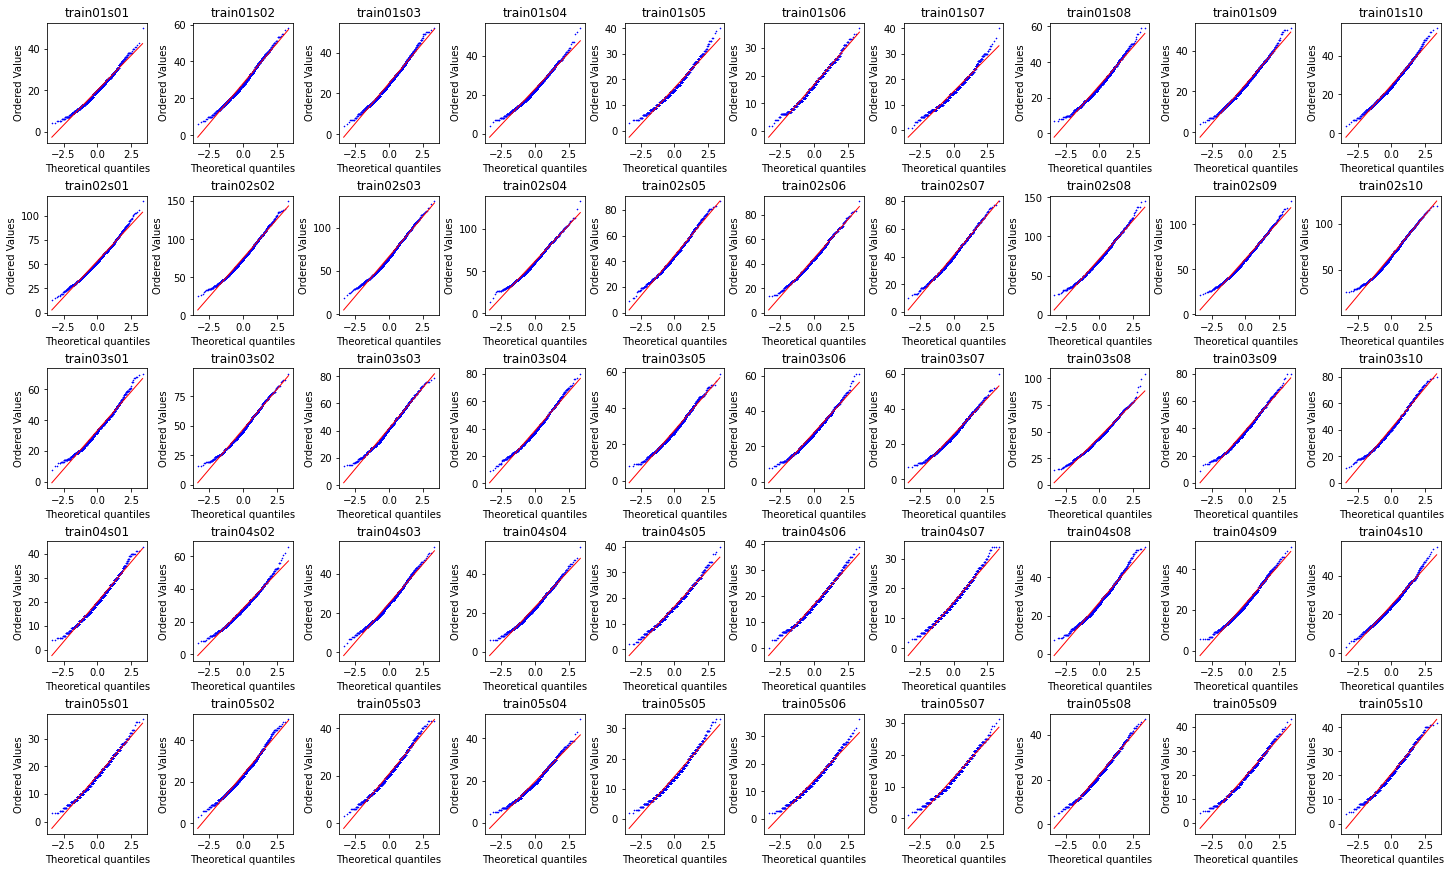

In [6]:
import scipy.stats
import pylab

fig, axs = plt.subplots(5,10, figsize=(20,12), constrained_layout=True)

for i, ax in enumerate(axs.ravel()):
    scipy.stats.probplot(globals()[s_train[i]], plot=ax, )#plot=pylab, )
    ax.get_lines()[0].set_marker('x')
    ax.get_lines()[0].set_markerfacecolor('r')
    ax.get_lines()[0].set_markersize(1.0)
    ax.get_lines()[1].set_linewidth(1.0)
    ax.set_title(s_train[i])

plt.show() # pylab.show()

- **All QQ distributions look fairly normal, with expected deviances typical of TS data.**

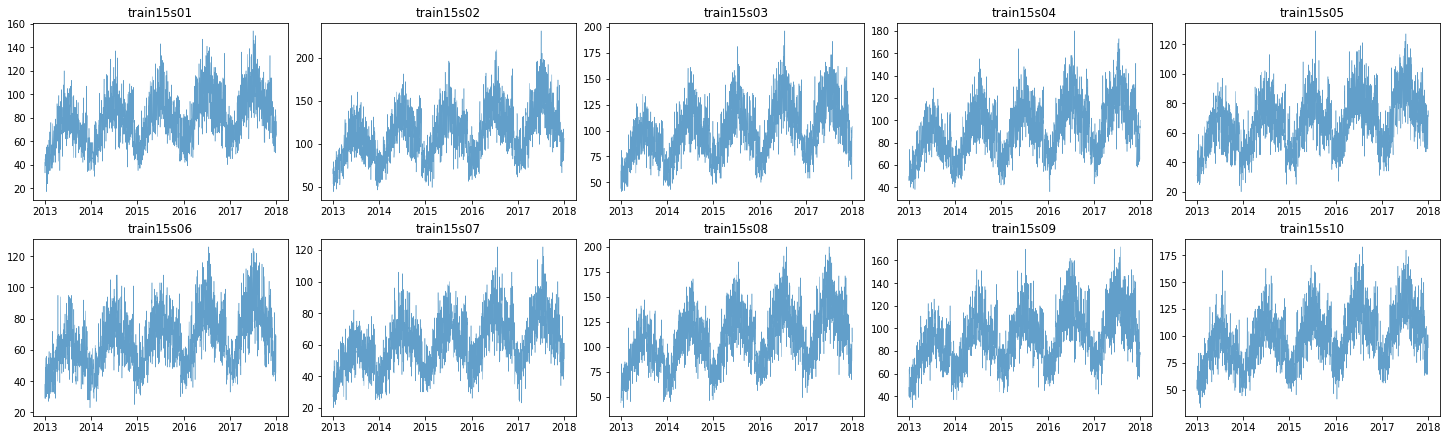

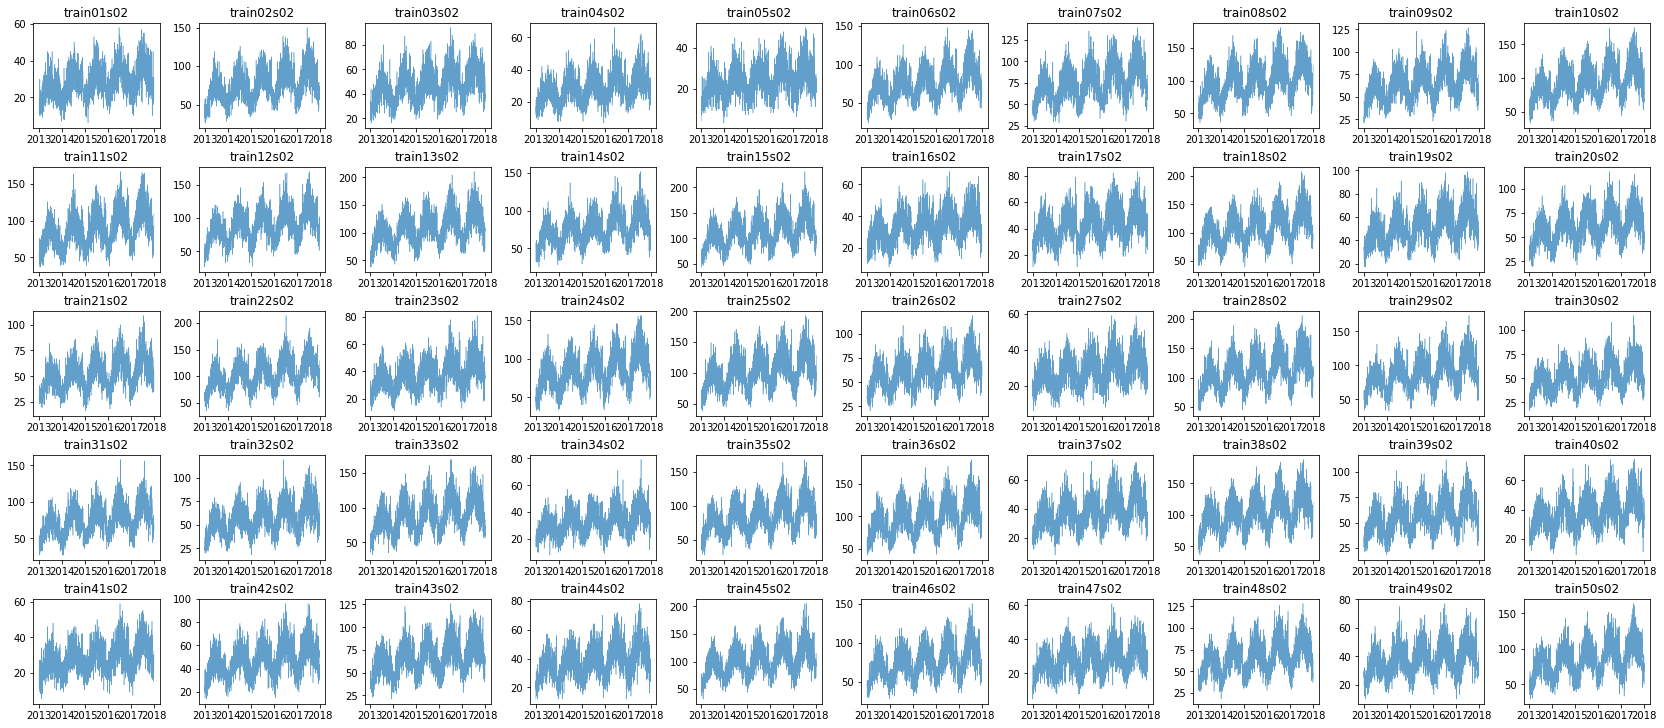

In [7]:

###? PLOT ALL ITEMS FOR A SINGLE STORE
def plot_store(store): #1 to 10
    fig, axs = plt.subplots(5,10,figsize=(23,10),constrained_layout=True)
    for i, ax in zip(range(1,51), axs.ravel()):
        n = 'train' + str(i).rjust(2, '0') + 's' + str(store).rjust(2, '0')
        ax.plot(globals()[n], linewidth=0.5, alpha=0.7)
        ax.set_title(n)

###? PLOT ALL STORES FOR A SINGLE ITEM
def plot_item(item): #1 to 50
    fig, axs = plt.subplots(2,5,figsize=(20,6),constrained_layout=True)
    for i, ax in zip(range(1,11), axs.ravel()):
        n = 'train' + str(item).rjust(2, '0') + 's' + str(i).rjust(2, '0')
        ax.plot(globals()[n], linewidth=0.5, alpha=0.7)
        ax.set_title(n)

plot_item(15)
plot_store(2)

- **all items and stores exhibit similar patterns. this is good, means we can develop 1 model and apply for all**

## Seasonal decompose

- Here we can already derive insights per product/store, generate descriptive analysis reports to show overall trends/seasonal variation, per item, per store, if required.
  - e.g. holidays sales volumes, sales against day of week, which products are more popular during holidays/on certain days of week, etc.

resid min: train05s07
resid max: train15s02
trend min: train41s07
trend max: train15s02


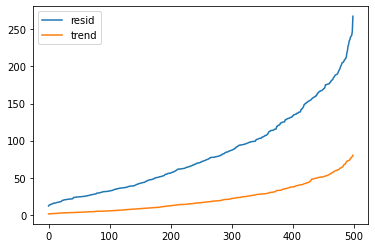

In [8]:
vars_resid, vars_trend = [],[]
for item in s_train:
    res = sm.tsa.seasonal_decompose(eval(item).dropna(), model='additive', period=365)
    vars_resid.append(res.resid.var())
    vars_trend.append(res.trend.var())
    
vars_resid = pd.Series(vars_resid)
vars_trend = pd.Series(vars_trend)
plt.plot(sorted(vars_resid), label='resid')
plt.plot(sorted(vars_trend), label='trend')
plt.legend()

print('resid min:', s_train[vars_resid.idxmin()])
print('resid max:', s_train[vars_resid.idxmax()])
print('trend min:', s_train[vars_trend.idxmin()])
print('trend max:', s_train[vars_trend.idxmax()])


after seasonal_decompose:
- **train05s07 has lowest residual variance**
- **train41s07 has lowest trend variance**
- **train15s02 has highest residual variance and trend variance.**
  - **We will develop models on this, on the premise that hopefully if our model is able to capture well, then it should perform well across all items/stores (yes, very summary method, but just sticking with this in the interest of time)**

quick plots after seasonal_decompose to see a sample spread across the items/stores, if more detailed model tuning per item-store set is required:

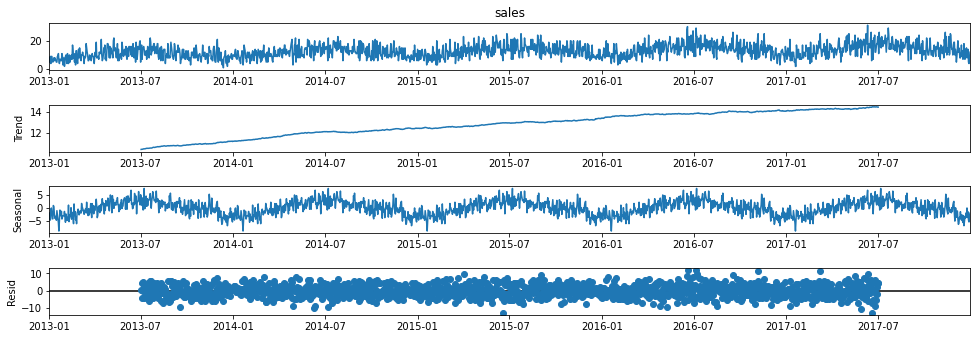

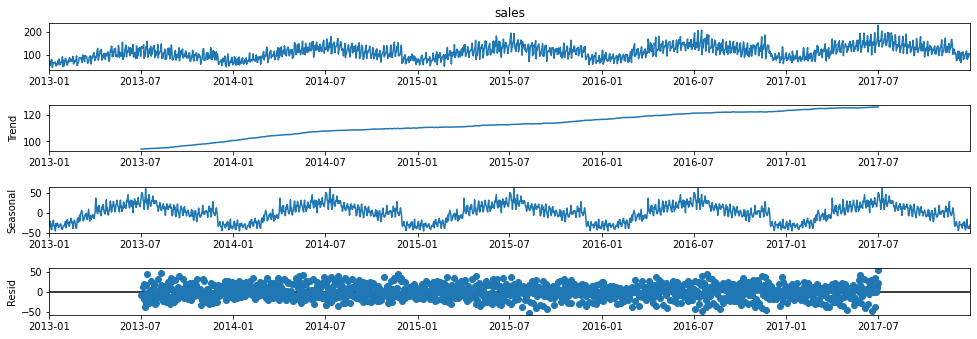

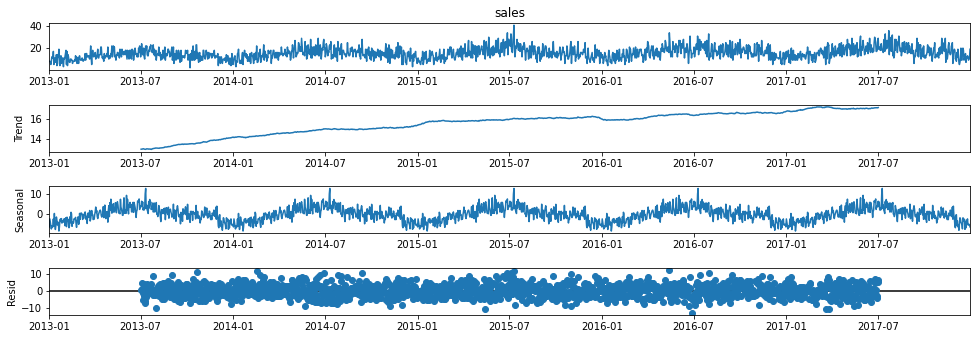

In [9]:
for item in ['train05s07', 'train15s02', 'train41s07']:
    res = sm.tsa.seasonal_decompose(eval(item).dropna(), model='additive', period=365)
    fig = res.plot()
    fig.set_figheight(5)
    fig.set_figwidth(15)
    plt.show()

## Check ACF & PACF

- Since our time series are not stationary, we will use ARIMA/SARIMA.
- Let's apply ACF/PACF plots on returns to make them stationary.

In [10]:
def plot_acfpacf(data, label='', lags=40, zero=False, ylim=1):
    fig,ax = plt.subplots(2,1,figsize=(15,7))

    sm.graphics.tsa.plot_acf(data, lags=lags, zero=zero, ax=ax[0])
    ax[0].set_ylim(-ylim, ylim)
    ax[0].set_title('ACF {}'.format(label))

    sm.graphics.tsa.plot_pacf(data, lags=lags, zero=zero, ax=ax[1])
    ax[1].set_ylim(-ylim, ylim)
    ax[1].set_title('PACF {}'.format(label))

    plt.show()


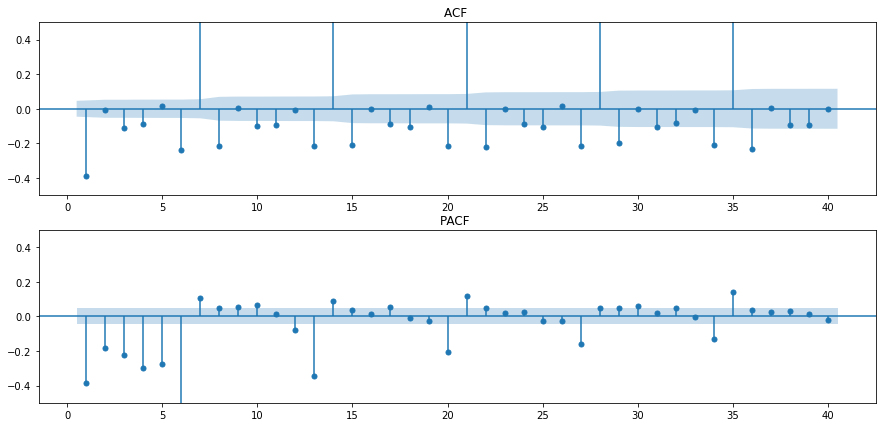

In [11]:
plot_acfpacf(train15s02.diff().dropna(), ylim=0.5)

- If we were building an AR model, 6 lags would be good.
- If we were building an MA model, 7 lags would be good.
- But ARIMA isn't so straightforward, so we have to iterate and test.

# Feature Engineering : Create Exogenous Features for SARIMAX

In [12]:
trn = train15s02[:1461]
tes = train15s02[1461:]

###? EXOG FEATURES: 
#? provide 365 day seasonal, 7 day seasonal,
sd_yrly = sm.tsa.seasonal_decompose(trn, model='additive', period=365, extrapolate_trend=1)  
sd_wkly = sm.tsa.seasonal_decompose(trn, model='additive', period=7,   extrapolate_trend=1)  

exog = pd.DataFrame({'yrly_s':sd_yrly.seasonal, 'wkly_s':sd_wkly.seasonal, })

# Tried adding extrapolated trends from seasonal decompose as exog features, but models became less accurate, probably because I'm not able to generate trends on unlabelled data reliably. So, removed it.

#? mark US holidays, also mark 7 days before holidays as 'preholidays' as people may buy items before the holidays.
holidays = pd.read_csv('./data/US Holiday Dates (2004-2021).csv')
holidays.set_index('Date', inplace=True)

exog['holiday']=0
exog['preholiday']=0

def addholidays(df):
    for d in holidays.index:
        if pd.to_datetime(d) in df.index:
            df.loc[d,'holiday']=1        
        if pd.to_datetime(d)-pd.Timedelta(7, "d") in df.index:
            df.loc[pd.to_datetime(d)-pd.Timedelta(1, "d"),'preholiday']=1
            df.loc[pd.to_datetime(d)-pd.Timedelta(2, "d"),'preholiday']=1
            df.loc[pd.to_datetime(d)-pd.Timedelta(3, "d"),'preholiday']=1
            df.loc[pd.to_datetime(d)-pd.Timedelta(4, "d"),'preholiday']=1
            df.loc[pd.to_datetime(d)-pd.Timedelta(5, "d"),'preholiday']=1
            df.loc[pd.to_datetime(d)-pd.Timedelta(6, "d"),'preholiday']=1
            df.loc[pd.to_datetime(d)-pd.Timedelta(7, "d"),'preholiday']=1

    df.dropna(inplace=True)
    return df

exog = addholidays(exog)

# exog.loc['2013-06-25':'2013-07-05'] # sanity check on 4th of july

###? GENERATE EXOG FOR PREDICTIONS
#? take mean of yearly and weekly seasonals from historical data
#? (we could just use the most recent year too)
exog2013 = exog.loc['2013'].copy(deep=True)
exog2014 = exog.loc['2014'].copy(deep=True)
exog2015 = exog.loc['2015'].copy(deep=True)
exog2016 = exog.loc['2016'].copy(deep=True)

exog2014.index = exog2014.index - pd.Timedelta(365, 'days')
exog2015.index = exog2015.index - pd.Timedelta(365*2, 'days')
exog2016.index = exog2016.index - pd.Timedelta(365*3, 'days')

exog2013.reset_index(inplace=True)
exog2014.reset_index(inplace=True)
exog2015.reset_index(inplace=True)
exog2016.reset_index(inplace=True)

exogagg = pd.concat([exog2013,exog2014,exog2015,exog2016])
exogpred = exogagg.groupby('date').mean()

#? and stripe in new holiday dates for prediction year
exogpred['holiday']=0
exogpred['preholiday']=0
# exogpred is now at year 2013
# for predictions 2017:
exog2017 = exogpred.copy(deep=True)
exog2017.index = exog2017.index + pd.Timedelta(365*4+1, 'days')

exog2018 = exogpred.copy(deep=True)
exog2018.index = exog2018.index + pd.Timedelta(365*5+1, 'days')

exog2017 = addholidays(exog2017)
exog2018 = addholidays(exog2018)

exog2017 = exog2017[:-1] # 2016 was a leap year, so when aggregated, all the dfs had 366 days
exog2018 = exog2018[:-1]

# #? we need to modify the trend line for predictions, right now they are just the mean of the train years.
# #? 2 options: A) use the current meaned trend, and offset the difference so the ends meet. (we will use this method)
# #?            B) just stripe in the trend from the most recent year, and offset the difference. (did not use this as the recent year has a sudden hump which seems year-specific)
# # exog2017['trend'] = exog['trend'][-365:].values #+ (exog['trend'][-1] - exog2017['trend'][0])
# # exog2018['trend'] = exog['trend'][-365:].values #+ (exog['trend'][-1] - exog2017['trend'][0]) + (exog2017['trend'][-1]-exog2017['trend'][0])
# exog2017['trend'] = exog2017['trend'] + (exog['trend'][-1] - exog2017['trend'][0])
# exog2018['trend'] = exog2018['trend'] + (exog2017['trend'][-1] - exog2018['trend'][0])

# plt.plot(exog['trend'])
# plt.plot(exog2017['trend'])
# plt.plot(exog2018['trend'])
# plt.title('exog trends: \ntrain and 2017 and 2018 prediction')
# plt.show()



# Model Selection

- since data isn't stationary, we will use ARIMA.
- use auto arima to find order and seasonal order

In [13]:
# # !pip install pmdarima


from pmdarima.arima import auto_arima

result = auto_arima(
    trn,
    X=exog,
    maxiter=150,
    d=1,
    start_p=1,
    start_q=1,
    max_p=6,
    max_q=1,
    max_order=11,
    m=7,
    D=1,
    start_P=1,
    start_Q=1,
    max_P=2,
    max_Q=1,
    seasonal=True,
    stationary=False,
    information_criterion='aic',
    alpha=0.05,
    test='kpss',
    seasonal_test='ocsb',
    stepwise=True,
    n_jobs=-1,
    method='lbfgs',
    error_action='trace',
    trace=True,
    random_state=0,
    n_fits=10,
    scoring='mse',)

result

###? <OUTPUT>
# Performing stepwise search to minimize aic
#  ARIMA(1,1,1)(1,1,1)[7]             : AIC=11043.406, Time=3.68 sec
#  ARIMA(0,1,0)(0,1,0)[7]             : AIC=12662.337, Time=0.56 sec
#  ARIMA(1,1,0)(1,1,0)[7]             : AIC=11930.773, Time=1.78 sec
#  ARIMA(0,1,1)(0,1,1)[7]             : AIC=11051.757, Time=1.76 sec
#  ARIMA(1,1,1)(0,1,1)[7]             : AIC=11042.078, Time=2.54 sec
#  ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=1.81 sec
#  ARIMA(1,1,1)(1,1,0)[7]             : AIC=inf, Time=3.18 sec
#  ARIMA(1,1,0)(0,1,1)[7]             : AIC=11516.093, Time=1.35 sec
#  ARIMA(2,1,1)(0,1,1)[7]             : AIC=11044.029, Time=3.69 sec
#  ARIMA(0,1,0)(0,1,1)[7]             : AIC=11845.514, Time=0.73 sec
#  ARIMA(2,1,0)(0,1,1)[7]             : AIC=11412.116, Time=1.78 sec
#  ARIMA(1,1,1)(0,1,1)[7] intercept   : AIC=11044.047, Time=3.77 sec

# Best model:  ARIMA(1,1,1)(0,1,1)[7]          
# Total fit time: 26.645 seconds
# ARIMA(maxiter=150, order=(1, 1, 1), scoring_args={},
#       seasonal_order=(0, 1, 1, 7), suppress_warnings=True,
#       with_intercept=False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=3.28 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=12558.363, Time=0.63 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=11799.940, Time=1.49 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=10863.035, Time=1.45 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=10865.030, Time=2.16 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=inf, Time=2.24 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=11710.692, Time=0.91 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=2.19 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=11377.364, Time=1.69 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=10864.992, Time=4.29 sec

Best model:  ARIMA(0,1,1)(0,1,1)[7]          
Total fit time: 21.262 seconds


ARIMA(maxiter=150, order=(0, 1, 1), scoring_args={},
      seasonal_order=(0, 1, 1, 7), suppress_warnings=True,
      with_intercept=False)

- **First time working with auto ARIMA, not sure if I entirely trust the results.**
- **Some further tests done below before finally deciding on SARIMAX(3,1,1)(1,1,1,7)**

In [18]:
###? DEFINE SCORING FUNCTIONS
def smape_score(a, f):
    return 1/len(a) * np.sum(2*np.abs(f-a)/(np.abs(a)+np.abs(f))*100)

def add_patch(legend, contents):
    from matplotlib.patches import Patch
    ax = legend.axes

    handles, labels = ax.get_legend_handles_labels()
    handles.append(Patch(facecolor='orange', edgecolor='r'))
    labels.append(contents)

    legend._legend_box = None
    legend._init_legend_box(handles, labels)
    legend._set_loc(legend._loc)
    legend.set_title(legend.get_title().get_text())


In [19]:

###? BATCH FIT MODEL ORDERS AND SEASONAL ORDERS
orders = [
    [1,1,1],
    [3,1,1],
    [3,1,1],
    [3,1,1],
    [6,1,1],
    [6,1,1],
]
seasonal_orders = [
    [0,1,1,7],
    [1,1,0,7],
    [1,1,1,7],
    [2,1,0,7],
    [0,1,1,7],
    [1,1,1,7],
]

models = []
for order, seasonal_order in zip(orders, seasonal_orders):
    models.append(sm.tsa.statespace.SARIMAX(trn, order=order, seasonal_order=seasonal_order, trend=None, exog=exog).fit())

,models,order,llf,aic,smape
4,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"([6, 1, 1], [0, 1, 1, 7])",-5414.019322,10854.038644,9.780167
5,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"([6, 1, 1], [1, 1, 1, 7])",-5414.020424,10856.040848,9.772280
2,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"([3, 1, 1], [1, 1, 1, 7])",-5415.438064,10852.876129,9.766082
0,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"([1, 1, 1], [0, 1, 1, 7])",-5418.955058,10853.910117,9.872929
3,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"([3, 1, 1], [2, 1, 0, 7])",-5532.477129,11086.954258,9.710331
1,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"([3, 1, 1], [1, 1, 0, 7])",-5612.908558,11245.817117,9.292630


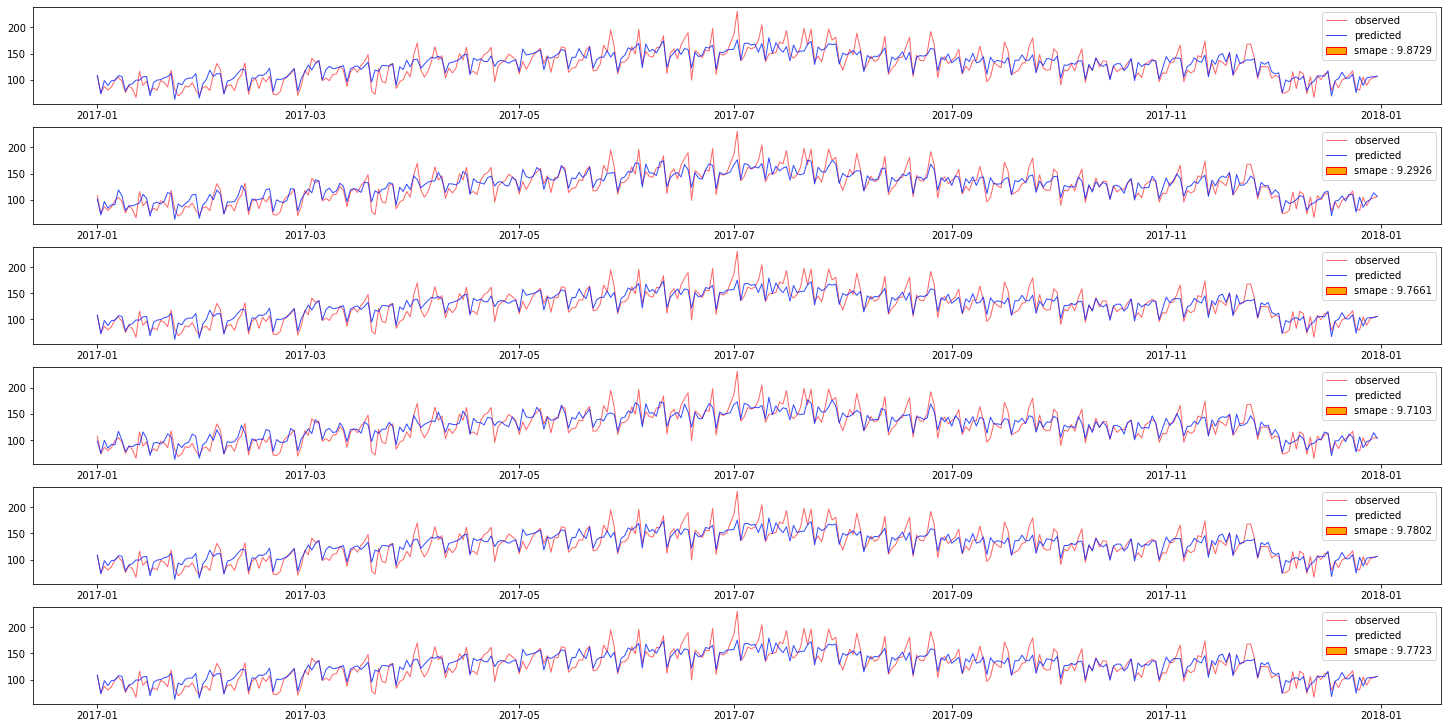

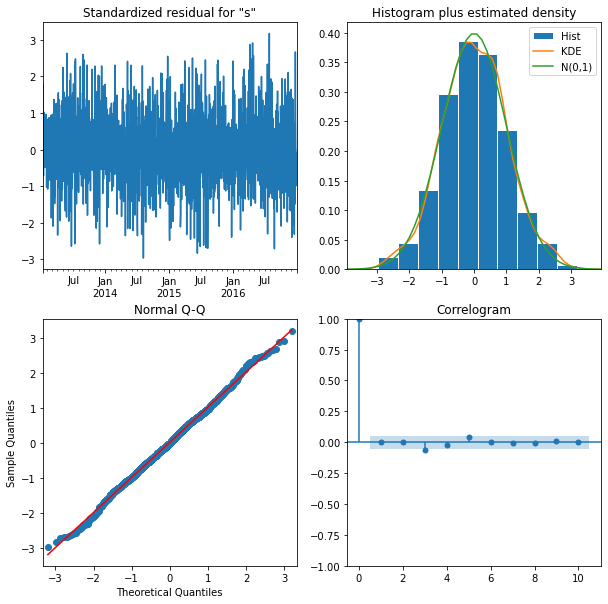

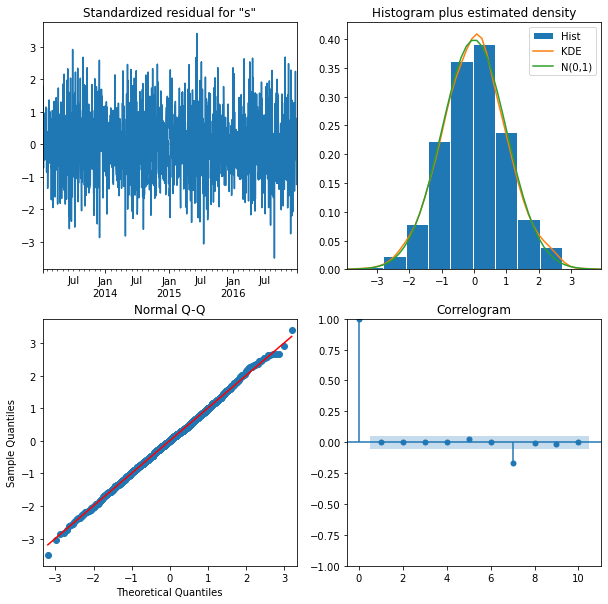

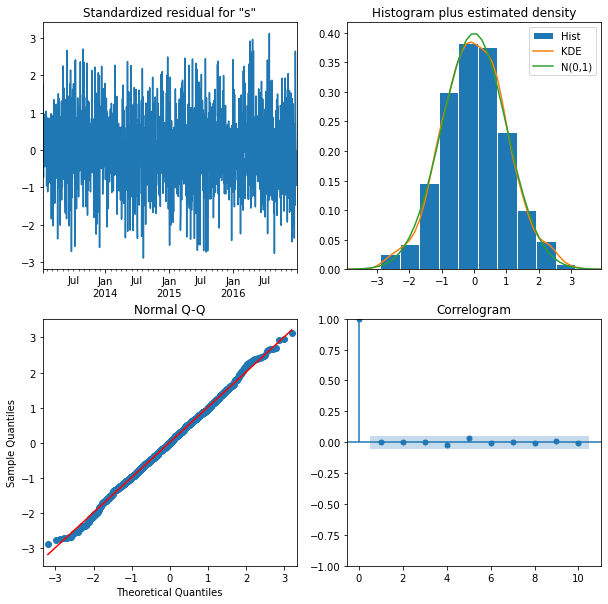

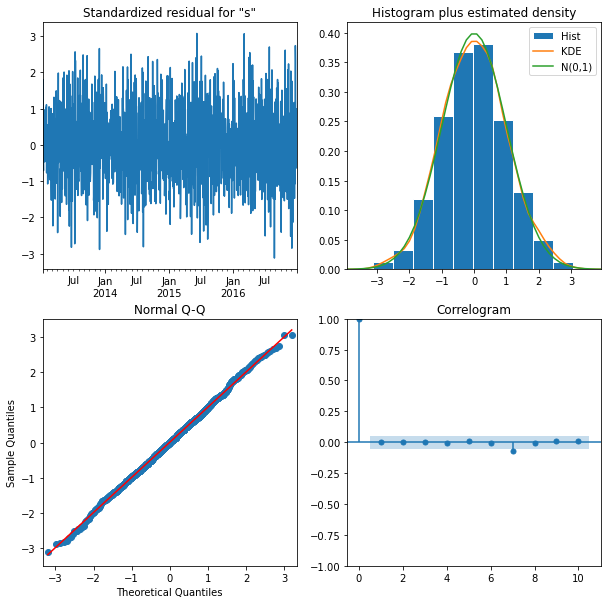

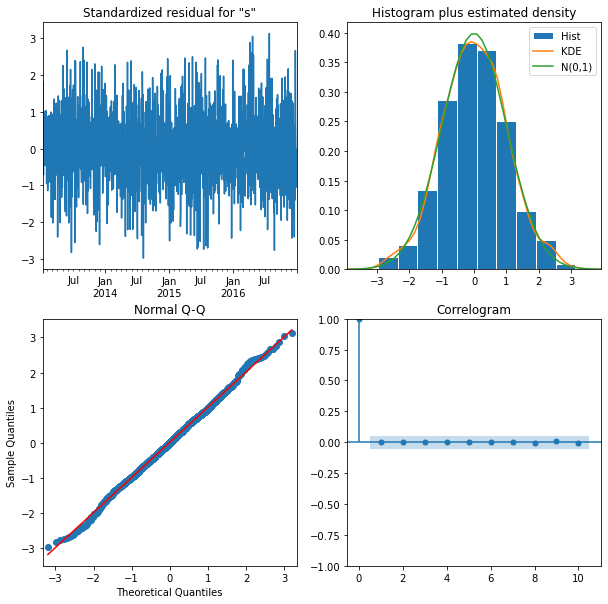

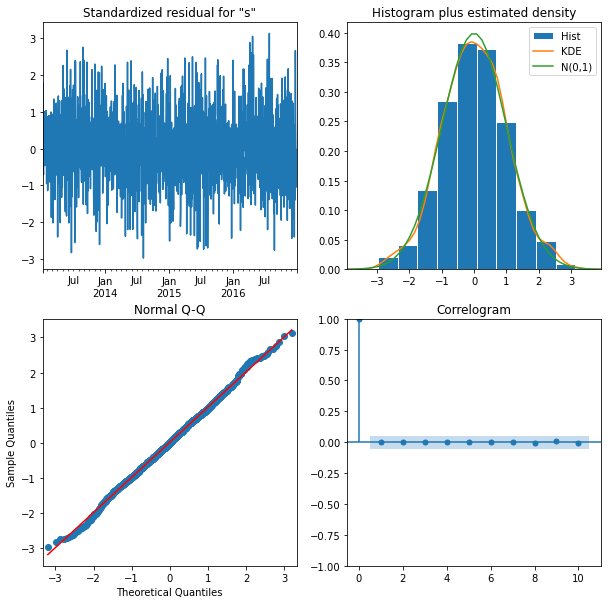

In [20]:
llfs,aics,preds,smapes,mses = [],[],[],[],[]

###? DEFINE PREDICTION DATE RANGE
start = tes.index[0]
end   = tes.index[-1]

###? RUN METRICS
for model in models:
    llfs.append(model.llf)
    aics.append(model.aic)

    pred = model.predict(start=start,end=end, exog=exog2017)
    preds.append(pred)
    smape = smape_score(tes.values, pred.values)
    smapes.append(smape)
    

###? DISPLAY METRICS
res_df = pd.DataFrame({
    'models': models,
    'order' : zip(orders,seasonal_orders),
    'llf'   : llfs,
    'aic'   : aics,
    'smape' : smapes,
})
display(res_df.sort_values('llf', ascending=False))

###? PLOT PREDICTIONS VS ACTUAL
fig, axs = plt.subplots(len(models),1,figsize=(20,10),constrained_layout=True)
for pred, ax, smape in zip(preds, axs.ravel(), smapes):
    ax.plot(tes,  alpha=0.6, linewidth=1, color='red'  , label='observed')
    ax.plot(pred, alpha=0.8, linewidth=1, color='#0020ff', label='predicted')
    patch = 'smape : {}'.format(round(smape, 4))
    lgd = ax.legend()
    add_patch(lgd, patch)

###? PLOT DIAGNOSTICS
for model in models:
    model.plot_diagnostics(figsize=(10,10))

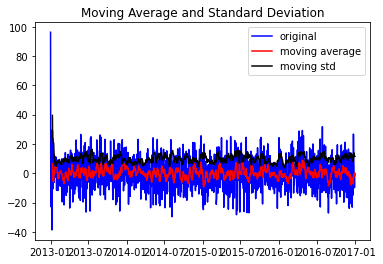

test statistic                        -23.629183
p-value                                      0.0
# lags used                                    2
num of obs used                             1458
maximized info criteria estimate    10712.080506
critical value ('1%')                  -4.379095
critical value ('5%')                  -3.836446
critical value ('10%')                 -3.555773
dtype: object

STATIONARY


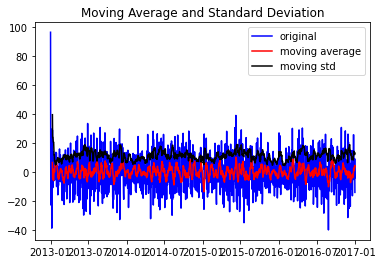

test statistic                        -11.990266
p-value                                      0.0
# lags used                                   20
num of obs used                             1440
maximized info criteria estimate    10879.508016
critical value ('1%')                  -4.379195
critical value ('5%')                  -3.836497
critical value ('10%')                 -3.555804
dtype: object

STATIONARY


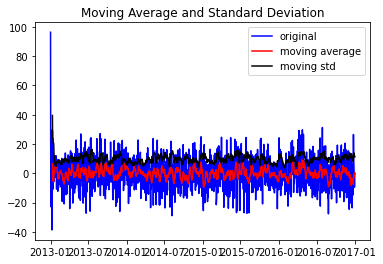

test statistic                       -39.201952
p-value                                     0.0
# lags used                                   0
num of obs used                            1460
maximized info criteria estimate    10707.62507
critical value ('1%')                 -4.379084
critical value ('5%')                 -3.836441
critical value ('10%')                -3.555769
dtype: object

STATIONARY


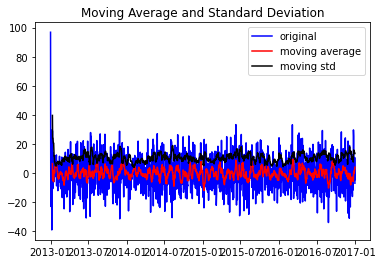

test statistic                        -11.583124
p-value                                      0.0
# lags used                                   20
num of obs used                             1440
maximized info criteria estimate    10829.534212
critical value ('1%')                  -4.379195
critical value ('5%')                  -3.836497
critical value ('10%')                 -3.555804
dtype: object

STATIONARY


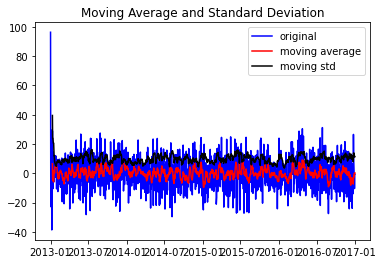

test statistic                        -39.164174
p-value                                      0.0
# lags used                                    0
num of obs used                             1460
maximized info criteria estimate    10704.534776
critical value ('1%')                  -4.379084
critical value ('5%')                  -3.836441
critical value ('10%')                 -3.555769
dtype: object

STATIONARY


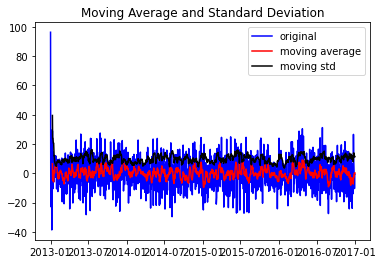

test statistic                        -39.142333
p-value                                      0.0
# lags used                                    0
num of obs used                             1460
maximized info criteria estimate    10704.564248
critical value ('1%')                  -4.379084
critical value ('5%')                  -3.836441
critical value ('10%')                 -3.555769
dtype: object

STATIONARY


In [21]:
for model in models:
    test_stationarity(model.resid, verbose=True)

Residuals on:
- [3,1,1],[1,1,1,7],
- [6,1,1],[0,1,1,7],
- [6,1,1],[1,1,1,7],
- look cleanest, no remaining autocorrelation on lag 7, in fact test stat for [3,1,1][1,1,1,7] was furthest away at -39.2.


# Conclusion
- **Higher lag models up to (6,1,1)(2,1,0,7) were trained, but [3, 1, 1], [1, 1, 1, 7] has best AIC, plots seem good, not too heavy training time, so we will proceed with that to batch out predictions for all the stores/items in the next notebook.**